In [90]:
import os.path
import datetime
import time
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import Counter

# Default parameters
RANDOM_STATE = 44
K_FOLD = 10
CUTOFF = 0.5

## Load data

In [91]:
data = pd.read_csv('data_for_student_case.csv', sep=',')
data.loc[:5]

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271
5,6,2015-11-09 14:26:25,MX,visaclassic,493161.0,79900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 23:04:26,MexicoAccount,email243511,ip112410,card159816


In [92]:
print(data.simple_journal.value_counts())
#print(data.shopperinteraction.value_counts())
print(data.shape)

Settled       236691
Refused        53346
Chargeback       345
Name: simple_journal, dtype: int64
(290382, 17)


- issuercountrycode: country where the card was issued
- txvariantcode: the card type that was used (subbrand of visa or master card)
- bin: card issuer identifier
- amount/currencycode: transaction amount in minor units (so 100 EUR = 100 euro cent)
- shoppercountrycode: IP address country
- shopperinteraction: Ecommerce if it was an online transaction, ContAuth if it was a (monthly) subscription
- simple_journal: Payment status. Authorised = “transaction approved and no fraud reported”, Refused = “transaction was declined, can be fraud, but can also be insufficient funds, etc”, Chargeback = “transaction was approved, but turned out to be fraud”
- bookingdate: only relevant for Chargebacks. Time stamp when the chargeback was reported. During simulation you may only use this knowledge after this date. So for example if on an email address a transaction ended in a chargeback, you can only block that email address after the booking date of the chargeback.
- cardverificationresponsesupplied: did the shopper provide his 3 digit CVC/CVV2 code?
- cvcresponsecode: Validation result of the CVC/CVV2 code: 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
- creationdate: Date of transaction
- accountcode: merchant’s webshop
- mail_id: Email address
- ip_id: Ip address
- card_id: Card number

## Data cleaning:

### Parsing

In [93]:
# Parse dates:
data.creationdate = pd.to_datetime(data.creationdate)
#data.bookingdate = pd.to_datetime(data.bookingdate)
data = data.assign(creation_weekday = data.creationdate.dt.weekday)
data = data.assign(creation_hour = data.creationdate.dt.hour)

In [94]:
# Parse currencies
currency_dict = {'MXN': 0.01*0.05, 'SEK': 0.01*0.11, 'AUD': 0.01*0.67, 'GBP': 0.01*1.28, 'NZD': 0.01*0.61}
data = data.assign(euro = list(map(lambda x,y: currency_dict[y]*x, data.amount, data.currencycode)))

In [95]:
# Parse CVC codes
#data = data.assign(cvcresponse = list(map(lambda x: 3 if x > 2 else x+0, data.cvcresponsecode)))
#0 = Unknown, 1=Match, 2=No Match, 3=Not checked

In [96]:
# Binary labels
label_dict = {'Chargeback': 1, 'Settled': 0, 'Refused': None}
data = data.assign(label = list(map(lambda x: label_dict[x], data.simple_journal)))

### cleaning

In [97]:
# Handle missing data
## delete entries:
data = data[pd.notnull(data['label'])]
#print(data.isnull().sum().sort_values(ascending=False))

# Change na to missing for non negative values during onehotencoding
data = data.fillna('missing')

In [98]:
# Parse Categorical text variables to int/id to enable OneHotEncoder
categorical_columns = ['txvariantcode', 'issuercountrycode', 'shoppercountrycode', 'shopperinteraction', 'accountcode', 'mail_id', 'ip_id', 'card_id']

def categorical_to_int(column_name):
    temp = pd.Categorical(data[column_name])
    temp_dict = dict(set(zip(temp, temp.codes)))
    data[column_name] = temp.codes
    return temp_dict

translate_dict = dict()
for column in categorical_columns:
    translate_dict[column] = categorical_to_int(column)

#data.head()

In [99]:
# Filter and parse to numpy array
input_dict = {'euro' : 'float64', 'txvariantcode' : 'int8', 'issuercountrycode' : 'int8', 'shoppercountrycode' : 'int16', 'shopperinteraction' : 'int8', 'accountcode' : 'int8', 'mail_id' : 'int32', 'ip_id' : 'int32', 'card_id' : 'int32', 'creation_weekday' : 'int8', 'creation_hour' : 'int8', 'label' : 'int8'}

data_in = data.loc[:, input_dict.keys()]
data_in = data_in.astype(dtype= input_dict)

# Create feature set and label set
X = data_in[data_in.columns[0:-1]].as_matrix()
y = data_in[data_in.columns[-1]].as_matrix()

In [100]:
# test for negative values, requirement of one hot encoding
for key in translate_dict:
    for value in translate_dict[key]:
        if translate_dict[key][value] == -1:
            print(key)

## Describe data:

In [101]:
print("Data types in: data_for_student_case.csv")
print(data_in.dtypes)
print("\nExample:")
print(data_in.iloc[10])

Data types in: data_for_student_case.csv
euro                  float64
txvariantcode            int8
issuercountrycode        int8
shoppercountrycode      int16
shopperinteraction       int8
accountcode              int8
mail_id                 int32
ip_id                   int32
card_id                 int32
creation_weekday         int8
creation_hour            int8
label                    int8
dtype: object

Example:
euro                      64.95
txvariantcode              2.00
issuercountrycode         76.00
shoppercountrycode        98.00
shopperinteraction         1.00
accountcode                1.00
mail_id                14107.00
ip_id                 187816.00
card_id                 1500.00
creation_weekday           5.00
creation_hour             18.00
label                      1.00
Name: 10, dtype: float64


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


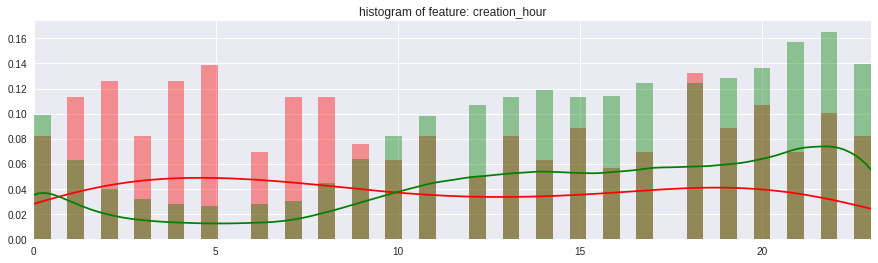

In [102]:
plt.figure(figsize=(15,4))
ax = plt.subplot()
ax.set_xlim([0,23])
sns.distplot(data_in['creation_hour'][data_in.label == 1], bins=50, color='red')
sns.distplot(data_in['creation_hour'][data_in.label == 0], bins=50, color='green')
ax.set_xlabel('')
ax.set_title('histogram of feature: creation_hour')
plt.savefig(os.path.join('./figs/', 'creation_hour'))
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


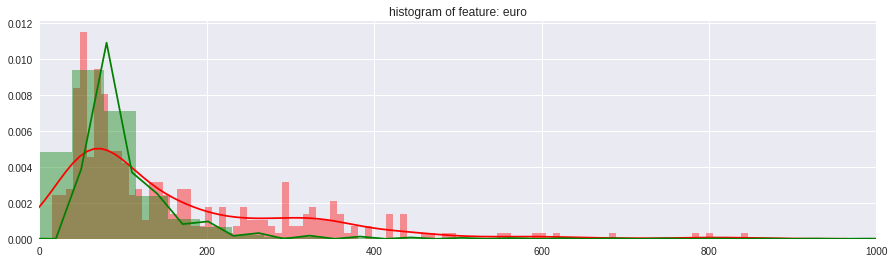

In [103]:
plt.figure(figsize=(15,4))
ax = plt.subplot()
ax.set_xlim([0,1000])
sns.distplot(data_in['euro'][data_in.label == 1], bins=100, color='red')
sns.distplot(data_in['euro'][data_in.label == 0], bins=100, color='green')
ax.set_xlabel('')
ax.set_title('histogram of feature: euro')
plt.savefig(os.path.join('./figs/', 'euro'))
plt.show()

## Train classifiers

In [104]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=RANDOM_STATE)
encoder = OneHotEncoder()

In [105]:
# Encode data
encoder = OneHotEncoder()
encoder.fit(X[:,1:])
X_enc = encoder.transform(X[:,1:])
numerical = X[:,0]

# Add euro column as numerical variable

# Select K best for faster fitting, no (significant) influence on performance measured
X_kbest = SelectKBest(chi2, k=1500).fit_transform(X_enc, y)
print(X_kbest.shape)

(237036, 1500)


### Train-test-split  and Kfold training functions

Both functions handle the data splitting, testing and scoring of a classifier and its hyper-parameters


In [106]:
def cutoff_predict(clf, x, cutoff):
    return (clf.predict_proba(x)[:,1]>cutoff).astype(int)

def test_clf_k_fold(clf, X, y, smote):
    y_pred = np.zeros(len(y))
    skf = StratifiedKFold(n_splits=K_FOLD)
    for train, test in skf.split(X, y):
        print("train:{} test:{}".format(train.shape, test.shape))
        X_train, y_train = X[train], y[train]
        print("X_train:{} y_train:{}".format(X_train.shape, y_train.shape))
        if smote:
            print("Oversample training data ... ")
            X_train, y_train = sm.fit_sample(X_train, y_train)
            print("SMOTE: X_train:{} y_train:{}".format(X_train.shape, y_train.shape))
        print("Fitting model ...")
        clf.fit(X_train, y_train)
        print("Predicting outcomes ...")
        y_pred[test] = cutoff_predict(clf, X[test], CUTOFF)
    
    print(confusion_matrix(y, y_pred))
    print(classification_report(y, y_pred))
    fpr, tpr, _ = roc_curve(y, y_pred)
    return y_pred, fpr, tpr

def test_clf_split(clf, X, y, ratio, smote):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio)
    if smote:
       print("Oversample training data ... ")
       X_train, y_train = sm.fit_sample(X_train, y_train)
    print("Fitting model ...")
    clf.fit(X_train, y_train)
    print("Predicting outcomes ...")
    y_pred = clf.predict_proba(X_test)[:,1]
    
    y_temp = cutoff_predict(clf, X_test, CUTOFF)
    print(confusion_matrix(y_test, y_temp))
    print(classification_report(y_test, y_temp))
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    return y_pred, fpr, tpr



#print(X[:100].shape)

### Random Forest

In [107]:
CUTOFF = 0.8
clf = RandomForestClassifier(max_depth=5, n_estimators=10, random_state=RANDOM_STATE)

#y_pred , fpr, tpr = test_clf_k_fold(clf, X[:1000], y[:1000])
y_pred , fpr_rf, tpr_rf = test_clf_split(clf, X_enc, y, 0.7, False)
# NOTE: this one takes a while 
y_pred , fpr_rf_sm, tpr_rf_sm = test_clf_split(clf, X_enc, y, 0.7, True)


Fitting model ...
Predicting outcomes ...
[[165689      0]
 [   237      0]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    165689
          1       0.00      0.00      0.00       237

avg / total       1.00      1.00      1.00    165926



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Oversample training data ... 
Fitting model ...
Predicting outcomes ...
[[165683      0]
 [   243      0]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    165683
          1       0.00      0.00      0.00       243

avg / total       1.00      1.00      1.00    165926



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Logistic Regression

In [108]:
CUTOFF = 0.8
clf = LogisticRegression()

y_pred , fpr_lr, tpr_lr = test_clf_split(clf, X_kbest, y, 0.7, False)
#y_pred , fpr_lr_full, tpr_lr_full = test_clf_split(clf, X_enc, y, 0.5, False) # Kbest performance check

# NOTE: this one takes a while 
y_pred , fpr_lr_sm, tpr_lr_sm = test_clf_split(clf, X_kbest, y, 0.7, True)

Fitting model ...
Predicting outcomes ...
[[165684      0]
 [   242      0]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    165684
          1       0.00      0.00      0.00       242

avg / total       1.00      1.00      1.00    165926

Oversample training data ... 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fitting model ...
Predicting outcomes ...
[[165685      6]
 [   213     22]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    165691
          1       0.79      0.09      0.17       235

avg / total       1.00      1.00      1.00    165926



### Multi Layer Perceptron Classifier

In [109]:
CUTOFF = 0.8
clf = MLPClassifier(hidden_layer_sizes=(100, 50), activation = 'logistic')

# NOTE: this both take a while 
y_pred , fpr_mlp, tpr_mlp = test_clf_split(clf, X_kbest, y, 0.7, False)
y_pred , fpr_mlp_sm, tpr_mlp_sm = test_clf_split(clf, X_kbest, y, 0.7, True)

Fitting model ...
Predicting outcomes ...
[[165681      1]
 [   232     12]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    165682
          1       0.92      0.05      0.09       244

avg / total       1.00      1.00      1.00    165926

Oversample training data ... 
Fitting model ...
Predicting outcomes ...
[[165664      6]
 [   236     20]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    165670
          1       0.77      0.08      0.14       256

avg / total       1.00      1.00      1.00    165926



## ROC curves

Creates a graphic showing the differences in scores of the multiple classifiers with or without SMOTE.

- RF: Random Forest
- LR: Logistic Regression
- MLP: Multi Layer Perceptron 

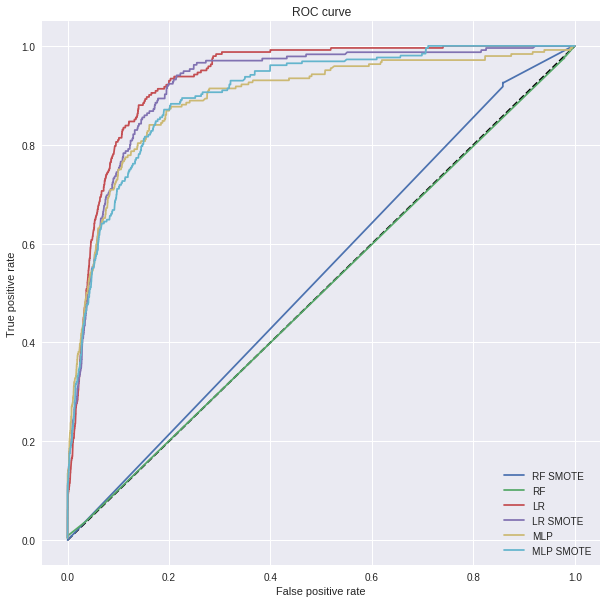

In [110]:
plt.figure(figsize=(10,10))
#plt.xlim(0, 0.2)
#plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_sm, tpr_rf_sm, label='RF SMOTE')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_lr, tpr_lr, label='LR')
#plt.plot(fpr_lr_full, tpr_lr_full, label='LR full')
plt.plot(fpr_lr_sm, tpr_lr_sm, label='LR SMOTE')
plt.plot(fpr_mlp, tpr_mlp, label='MLP')
plt.plot(fpr_mlp_sm, tpr_mlp_sm, label='MLP SMOTE')
# See below
# plt.plot(fpr_dt, tpr_dt, label='DT')
#plt.plot(fpr_dt_sm, tpr_dt_sm, label='DT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(os.path.join('./figs/', 'ROC_curves'))
plt.show()


## Blackbox: auto-encoder

In [111]:
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# The label to learn
label = 0

# Create feature set
X = data_in[data_in.columns[0:-1]][data_in.label == label].as_matrix()
# Encode data
encoder = OneHotEncoder()
encoder.fit(X[:,1:])
X_in = encoder.transform(X[:,1:])
numerical = X[:,0]

# Add euro column as numerical variable
print(X_in.shape)
print(type(X_in))

(236691, 625869)
<class 'scipy.sparse.csr.csr_matrix'>


### Model definition

In [112]:

# Unfortunately we did not manage to get this part working, to be sure the rest of the notebook runs as expected
# we outcommented critical parts that might potentially crash the kernel.

# Define graph:
#  Feed forward:
#     input x > weights 
#     > encoder: hidden layer 1 (activation funtion) 
#     > weights > decoder: hidden layer 2 (activation funtion) 
#     > weights > output y
#
#  Backpropagation
#    Compare input and output using a cost function e.g. cross entropy, ...
#
#    Learn using optimizer e.g. Stochastic Gradient Descent, ADAGrad, ...

# Hyper-parameters
learning_rate = 0.001
training_iteration = 10
batch_size = 256
display_step = 1

data_dir = '.'

# Network parameters
n_input = X_in[1].shape[1]
n_hidden_1 = 1000
n_hidden_2 = 500
X = tf.placeholder("float", [None, n_input], name='x')
    
def auto_encoder_model(x):
    # Define weights
    weights = {
        'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
        'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'decoder_h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
        'decoder_h4': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    }
    # Define biases
    biases = {
        'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'decoder_b3': tf.Variable(tf.random_normal([n_hidden_1])),
        'decoder_b4': tf.Variable(tf.random_normal([n_input])),
    }
    
    # Encoder
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))

    # Decoder
    layer_3 = tf.nn.tanh(tf.add(tf.matmul(layer_2, weights['decoder_h3']), biases['decoder_b3']))
    layer_4 = tf.nn.tanh(tf.add(tf.matmul(layer_3, weights['decoder_h4']), biases['decoder_b4']))
    
    # layer 4 represents the output
    return layer_4

# Define model: auto_encoder_model
model = auto_encoder_model(X)

y_pred = model
# Targets are the input data to train the encoder to recognise itself
y_true = X

# Define cost function: cross entropy
cost_function = -tf.reduce_sum(y_true*tf.log(y_pred))

# Define optimizer: gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)


In [113]:

#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
#    
#    avg_cost = 0.
#    total_batch = TODO
#    
#    # Training cycle
#    for epoch in range(training_epochs):
#        
#        # Batch cycle
#        for i in range(total_batch):
#            sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys})
#            avg_cost += sess.run(cost_function, feed_dict={x: batch_xs, y: batch_ys})/total_batch
#    
#    
#    # Training cycle
#    for iteration in range(training_iteration):
#        avg_cost = 0.
#        total_batch = int(mnist.train.num_examples/batch_size)
#        # Loop over all batches
#        for i in range(total_batch):
#            batch_xs = TODO
#            
#            # Fit training using batch data
#            sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys})
#            
#            # Compute the average loss
#            avg_cost += sess.run(cost_function, feed_dict={x: batch_xs, y: batch_ys})/total_batch
#        # Display logs per iteration step
#        if iteration % display_step == 0:
#            print("Iteration: {} cost={}".format((iteration + 1), avg_cost))
#            
#    # 
#    y_pred = tf.equal(tf.argmax(model, 1), tf.argmax(y, 1))

## Whitebox: Decision Tree

This decision tree uses the KFold test function implemented earlier.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
KFOLD = 10
CUTOFF = 0.8

clf = DecisionTreeClassifier()

#clf = y_pred , fpr_dt, tpr_dt = test_clf_k_fold(clf, X_kbest, y, False)
clf = y_pred , fpr_dt_sm, tpr_dt_sm = test_clf_k_fold(clf, X_kbest, y, True)

train:(213331,) test:(23705,)
X_train:(213331, 1500) y_train:(213331,)
Oversample training data ... 
SMOTE: X_train:(426042, 1500) y_train:(426042,)
Fitting model ...
Predicting outcomes ...
train:(213332,) test:(23704,)
X_train:(213332, 1500) y_train:(213332,)
Oversample training data ... 
SMOTE: X_train:(426044, 1500) y_train:(426044,)
Fitting model ...
Predicting outcomes ...
train:(213332,) test:(23704,)
X_train:(213332, 1500) y_train:(213332,)
Oversample training data ... 


In [ ]:
plt.figure(figsize=(10,10))
#plt.xlim(0, 0.2)
#plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
# See below
#plt.plot(fpr_dt, tpr_dt, label='DT')
plt.plot(fpr_dt_sm, tpr_dt_sm, label='DT SMOTE')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(os.path.join('./figs/', 'ROC_curves'))
plt.show()

## Plots

In [ ]:
#data.groupby('simple_journal').plot(x='creationdate', y='euro', style=".", figsize=(20,10))

In [ ]:
#%matplotlib inline
#temp = data[['shoppercountrycode', 'simple_journal']]
#plt.figure(figsize=(20,50))
#sns.heatmap(temp, cmap='RdYlGn_r', linewidths=0.5, annot=True)

In [ ]:
#plt.figure(figsize=(14,12*4))
#gs = gridspec.GridSpec(12, 1)
#for i, cn in enumerate(data_in.columns[:12]):
#    ax = plt.subplot(gs[i])
#    sns.distplot(data_in[cn][data_in.label == 1], bins=50)
#    sns.distplot(data_in[cn][data_in.label == 0], bins=50)
#    ax.set_xlabel('')
#    ax.set_title('histogram of feature: ' + str(cn))
#plt.show()